# Human Activity Recognition - Exploratory Data Analysis
Here we analyize the [Human Activity Recognition data](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones) set generously made available through the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). 

As per the [README](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names), 
> The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years
> Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist

The goal of this notebook is to do load the 561 features provided for the experiments as well as correspondings labels, explore the data and set up a classification task.

## Load Data

In [1]:
import os
import pickle as pkl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
# location of training and test data
DATA_DIR = os.path.join('..', 'data')
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test')

# name of feature and label files
FEATURE_TRAIN_FILE = 'X_train.txt'
FEATURE_TEST_FILE = 'X_test.txt'
LABEL_TRAIN_FILE = 'y_train.txt'
LABEL_TEST_FILE = 'y_test.txt'

# load features
feature_train_df = pd.read_csv(os.path.join(TRAIN_DATA_DIR, FEATURE_TRAIN_FILE), delim_whitespace=True, header=None)
feature_test_df = pd.read_csv(os.path.join(TEST_DATA_DIR, FEATURE_TEST_FILE), delim_whitespace=True, header=None)

# load labels
label_train_df = pd.read_csv(os.path.join(TRAIN_DATA_DIR, LABEL_TRAIN_FILE), sep=' ', header=None)
label_test_df = pd.read_csv(os.path.join(TEST_DATA_DIR, LABEL_TEST_FILE), sep=' ', header=None)

In [3]:
LABELS_METADATA = 'activity_labels.txt'

with open(os.path.join(DATA_DIR, LABELS_METADATA)) as file_conn:
    activity_labels = {int(line[0]): line.rstrip().split(' ')[1] for line in file_conn.readlines()}
    
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [4]:
label_train_df.columns = ['labels']
label_test_df.columns = ['labels']

(label_train_df.shape[0], label_test_df.shape[0])

(7352, 2947)

## Define Labels
We load the training and test data and see that the labels are roughly uniformly distributed between the 6 categories:
    - Walking
    - Walking (up stairs)
    - Walking (down stairs)
    - Sitting
    - Standing
    - Laying
Thus the first label we define is `walking` and `not walking`.

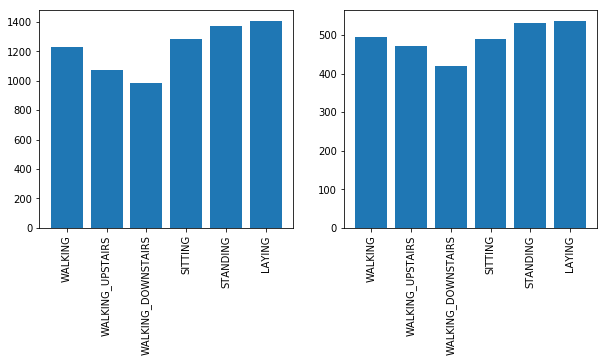

In [5]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
labels, label_counts = np.unique(label_train_df, return_counts=True)
plt.bar(x=labels, height=label_counts)
plt.xticks(labels, [activity_labels[label] for label in labels], rotation='vertical')

plt.subplot(1, 2, 2)
labels, label_counts = np.unique(label_test_df, return_counts=True)
plt.bar(x=labels, height=label_counts)
plt.xticks(labels, [activity_labels[label] for label in labels], rotation='vertical');

In [6]:
label_train_df['walking'] = np.where(label_train_df['labels'] < 4, 1, 0)
label_test_df['walking'] = np.where(label_test_df['labels'] < 4, 1, 0)

## Load and Standardize Features

In [7]:
FEATURES_METADATA = 'features.txt'

features_metadata = pd.read_csv(os.path.join(DATA_DIR, FEATURES_METADATA), delim_whitespace=True, header=None)

# rename duplicate columns
column_names, counts = np.unique(features_metadata[1], return_counts=True)
column_counts = dict(zip(column_names, counts))

for column_name, count in column_counts.items():
    if count > 1:
        dup_idx = features_metadata[1] == column_name
        features_metadata[1][dup_idx] = [
            '{}-{}'.format(dup, idx)
            for idx, dup in enumerate(features_metadata[1][dup_idx])
        ]

feature_train_df.columns = features_metadata[1]
feature_test_df.columns = features_metadata[1]

feature_train_df.head()

/home/ssoi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [8]:
feature_scaler = StandardScaler()

feature_scaler.fit(feature_train_df)
feature_train_scaled_df = pd.DataFrame(feature_scaler.transform(feature_train_df))
feature_train_scaled_df.columns = feature_train_df.columns

feature_train_scaled_df.head()

1,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.200642,-0.063683,-0.419628,-0.868814,-0.939441,-0.737529,-0.859817,-0.939019,-0.766437,-0.856036,...,-0.795359,0.025960,-0.276399,-0.360603,0.062940,-0.778427,-0.026080,-0.687219,0.407946,-0.007568
1,0.055948,0.031486,-0.253908,-0.875426,-0.923902,-0.849304,-0.868531,-0.921998,-0.848928,-0.871359,...,0.130614,-0.897357,-0.767990,0.133011,-0.021461,-1.218805,1.484470,-0.694138,0.409117,0.007875
2,0.073515,-0.043416,-0.076295,-0.869039,-0.907760,-0.893785,-0.863137,-0.898854,-0.896701,-0.863323,...,1.152336,-0.260878,-0.438316,-0.377840,0.391976,0.151207,1.704201,-0.702239,0.410288,0.026502
3,0.066696,-0.208422,-0.249712,-0.870626,-0.940022,-0.921805,-0.864503,-0.938124,-0.925279,-0.863323,...,1.112769,0.591045,0.463155,-0.135025,-0.033637,1.037851,-1.003019,-0.701684,0.414650,0.031714
4,0.030469,0.027587,-0.109848,-0.875188,-0.934878,-0.921343,-0.867384,-0.931789,-0.928028,-0.870260,...,-0.149577,-0.138515,-0.240313,0.340406,0.268486,1.125918,-1.276282,-0.700152,0.425463,0.045225


## Principal Components Analysis of Feature Matrix
We conduct PCA on the standardized feature matrix. The first PC epxlains 50% of the variance in the data. There's a big elbow as the 2nd PC explains < 10%, in contrast.

We plot the first 4 PCs for the training data and see that the first PC separates `walking` and `not walking` labeled observations. When we project the test data onto PCs obtained from the training data we see the same (and potentially stronger) pattern on the first PC with `walking` and `not walking` instances clearly.

In [9]:
features_pca = PCA(n_components=561, svd_solver='full')
features_reduced = features_pca.fit_transform(feature_train_scaled_df)

Text(0,0.5,'% Variance Explained')

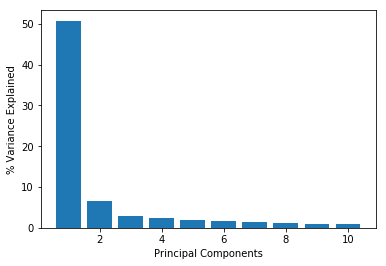

In [10]:
plt.bar(x=np.arange(10)+1, height=features_pca.explained_variance_ratio_[0:10] * 100)
plt.xlabel('Principal Components')
plt.ylabel('% Variance Explained')

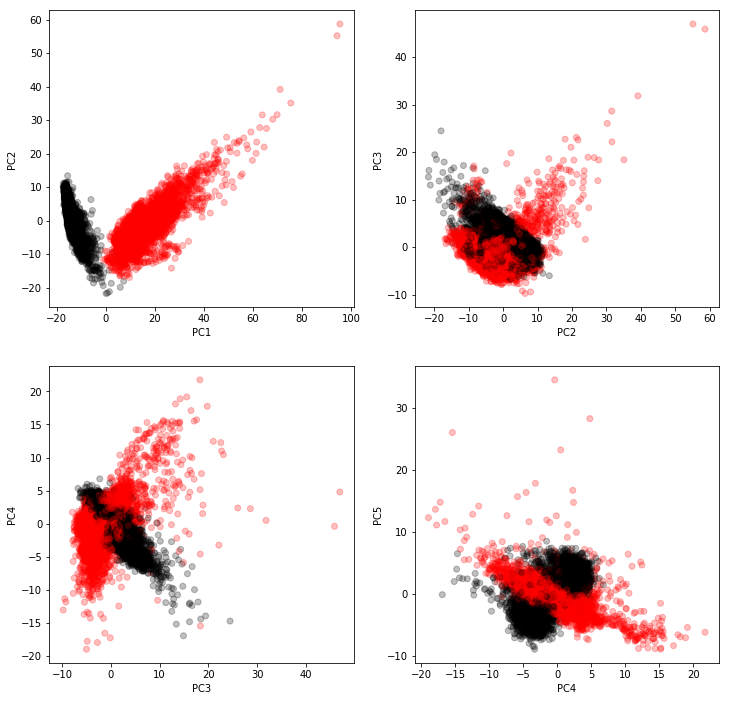

In [11]:
label_colors = np.where(label_train_df['walking'] == 0, 'black', 'red')

plt.figure(figsize=(12, 12))

for idx in range(4):
    plt.subplot(2, 2, idx + 1)
    plt.scatter(x=features_reduced[:, idx], y=features_reduced[:, idx + 1], c=label_colors, alpha=0.25)
    plt.xlabel('PC{}'.format(idx + 1))
    plt.ylabel('PC{}'.format(idx + 2))

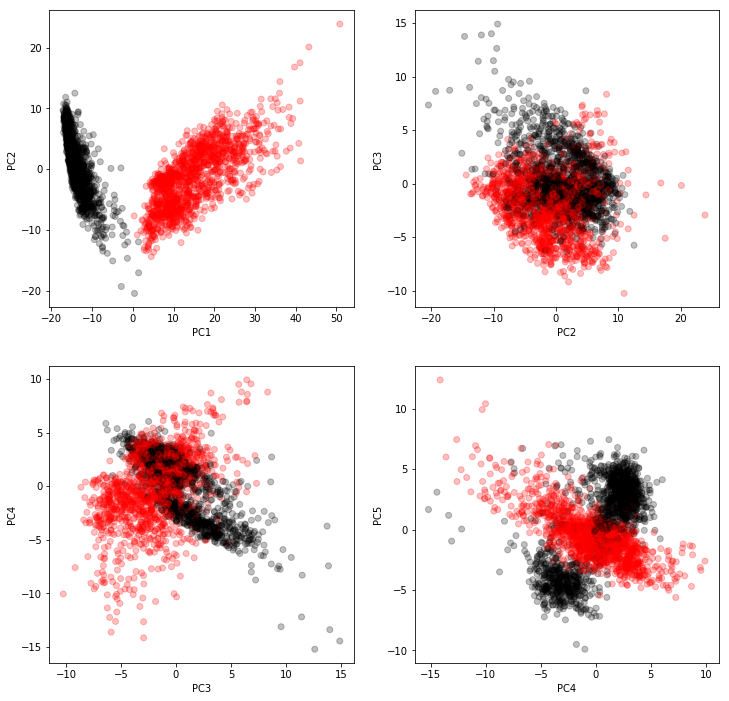

In [12]:
feature_test_scaled_df = pd.DataFrame(feature_scaler.transform(feature_test_df))
feature_test_scaled_df.columns = feature_train_scaled_df.columns
features_test_reduced = features_pca.transform(feature_test_scaled_df)

label_colors = np.where(label_test_df['walking'] == 0, 'black', 'red')

plt.figure(figsize=(12, 12))

for idx in range(4):
    plt.subplot(2, 2, idx + 1)
    plt.scatter(x=features_test_reduced[:, idx], y=features_test_reduced[:, idx + 1], c=label_colors, alpha=0.25)
    plt.xlabel('PC{}'.format(idx + 1))
    plt.ylabel('PC{}'.format(idx + 2))

## Save Results
We will save the scaled feature matrix and the scaler with the constants necessary to scale a new data set. In addition, we will also save a reconstructed matrix with the leading PC omitted. As the leading PC seems to capture most (but not all) of the signal related to walking versus standing, this could pose a more challenging (but still tractable) classification problem.

In [13]:
feature_train_scaled_missing_df = feature_train_scaled_df @ features_pca.components_[1:,:].T
feature_test_scaled_missing_df = feature_test_scaled_df @ features_pca.components_[1:,:].T

In [14]:
feature_train_scaled_df.to_pickle(os.path.join(DATA_DIR, 'feature_train_scaled.pkl'))
feature_test_scaled_df.to_pickle(os.path.join(DATA_DIR, 'feature_test_scaled.pkl'))

feature_train_scaled_missing_df.to_pickle(os.path.join(DATA_DIR, 'feature_train_scaled_missing.pkl'))
feature_test_scaled_missing_df.to_pickle(os.path.join(DATA_DIR, 'feature_test_scaled_missing.pkl'))

In [15]:
with open(os.path.join(DATA_DIR, 'feature_scaler.pkl'), 'wb') as filename:
    pkl.dump(feature_scaler, filename)